In [1]:
# data
import torch
torch.manual_seed(1337)

B, T = 4, 8
def gen_dataset(data):
    ix_rand = torch.randint(len(data) - T, (B,))
    x = torch.stack([data[i:i+T] for i in ix_rand])
    y = torch.stack([data[i+1:i+T+1] for i in ix_rand])
    return x, y

with open('./data/shakespeare.txt', 'r') as f:
    text = f.read()
vocab = sorted(list(set(''.join(text))))
V = len(vocab)

# tokenize
encode = { c:i for i,c in enumerate(vocab) }
decode = { i:c for i,c in enumerate(vocab) }
data = torch.tensor([encode[c] for c in text], dtype=torch.long)

# dataload
n1, n2 = int(0.8*len(data)), int(0.9*len(data))
Xtr_BT, Ytr_BT = gen_dataset(data[:n1])
Xdev_BT, Ydev_BT = gen_dataset(data[n1:n2])
Xte_BT, Yte_BT = gen_dataset(data[n2:])

print(Xtr_BT)
print(Ytr_BT)

for b in range(B):
    print('batch', b)
    for t in range(T):
        context = Xtr_BT[b, :t+1]
        target = Ytr_BT[b, t]
        print('x:', context, '->', 'y:', target)

tensor([[58, 63,  8,  0,  0, 19, 24, 27],
        [39, 59, 45, 46, 58,  1, 46, 43],
        [49, 43, 57,  1, 53, 50, 42,  1],
        [52, 41, 47, 43, 52, 58,  1, 56]])
tensor([[63,  8,  0,  0, 19, 24, 27, 33],
        [59, 45, 46, 58,  1, 46, 43,  1],
        [43, 57,  1, 53, 50, 42,  1, 46],
        [41, 47, 43, 52, 58,  1, 56, 47]])
batch 0
x: tensor([58]) -> y: tensor(63)
x: tensor([58, 63]) -> y: tensor(8)
x: tensor([58, 63,  8]) -> y: tensor(0)
x: tensor([58, 63,  8,  0]) -> y: tensor(0)
x: tensor([58, 63,  8,  0,  0]) -> y: tensor(19)
x: tensor([58, 63,  8,  0,  0, 19]) -> y: tensor(24)
x: tensor([58, 63,  8,  0,  0, 19, 24]) -> y: tensor(27)
x: tensor([58, 63,  8,  0,  0, 19, 24, 27]) -> y: tensor(33)
batch 1
x: tensor([39]) -> y: tensor(59)
x: tensor([39, 59]) -> y: tensor(45)
x: tensor([39, 59, 45]) -> y: tensor(46)
x: tensor([39, 59, 45, 46]) -> y: tensor(58)
x: tensor([39, 59, 45, 46, 58]) -> y: tensor(1)
x: tensor([39, 59, 45, 46, 58,  1]) -> y: tensor(46)
x: tensor([39, 5

In [7]:
""" model: transformer (Vaswani et al. 2017 https://arxiv.org/abs/1706.03762)

Dimension key:

B: batch size
T: sequence length
V: vocabulary size
D: model dimension (d_model/embedding_dim)
H: number of attention heads in a layer
K: size of each attention key or value (d_kv)
N: number of transformer blocks
"""
# model
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)
B, T, V, D, H, K, N = 4, 8, len(vocab), 64, 4, 16, 4

class SA(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.Wq_DK = nn.Linear(D,K,bias=False)
        self.Wk_DK = nn.Linear(D,K,bias=False)
        self.Wv_DK = nn.Linear(D,K,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

    def forward(self, X_BTD):
        B,T,D = X_BTD.shape
        # 1. project to learned QKV subspaces Q=WqX, K=WkX, V=WvX
        Q_BTK, K_BTK, V_BTK = self.Wq_DK(X_BTD), self.Wk_DK(X_BTD), self.Wv_DK(X_BTD)

        # 2. A(QKV) = softmax(QK^T/sqrt(d_k))V
        A_BTT = Q_BTK @ K_BTK.transpose(-2, -1) * D**-0.5 # todo, pytorch transpose api
        A_BTT = A_BTT.masked_fill(self.tril[:T, :T]==0, float('-inf'))
        A_BTT = F.softmax(A_BTT, dim=-1) # todo, when dim=-1?
        A_BTK = A_BTT @ V_BTK

        return A_BTK

class MHA(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.heads = nn.ModuleList([SA(K) for _ in range(H)])
        self.Wp = nn.Linear(D, D)

    def forward(self, X_BTD):
        # torch.cat(4x8x16, dim=-1) -> (B:4, T:8, D:64)
        X_BTD = torch.cat([h(X_BTD) for h in self.heads], dim=-1)
        X_BTD = self.Wp(X_BTD) # linear projection for residual pathway
        return X_BTD

class FFN(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D, 4*D), # projecting up to extract features from context embeddings
            nn.ReLU(),
            nn.Linear(4*D, D), # projecting back down to residual pathway
        )

    def forward(self, X_BTK):
        return self.net(X_BTK)

class Block(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.mha = MHA(H, D//H)
        self.ffn = FFN(D)

    def forward(self, X_BTD):
        # residuals: see (He et al. 2015 https://arxiv.org/abs/1512.03385)
        X_BTD = X_BTD + self.mha(X_BTD)
        X_BTD = X_BTD + self.ffn(X_BTD)
        return X_BTD




class Transformer(nn.Module):
    def __init__(self, V):
        super().__init__()
        self.token_embedding_table = nn.Embedding(V, D)
        self.position_embedding_table = nn.Embedding(T, D)
        self.blocks = nn.Sequential(*[Block(D, H) for _ in range(N)])
        self.lm_head = nn.Linear(D, V)

    def forward(self, X_BT, Y_BT=None): # Y_BT is optional for inference
        B, T = X_BT.shape

        # 1. embedding: BTD
        Xtok_BTD = self.token_embedding_table(X_BT)
        Xpos_TD = self.position_embedding_table(torch.arange(T))
        X_BTD = Xtok_BTD + Xpos_TD

        # 2. N transformer blocks: Nx(BTD -> BTK -> BTD)
        X_BTD = self.blocks(X_BTD)

        # 3. logits: BTD -> BTV
        logits_BTV = self.lm_head(X_BTD)
 
        # 4. if training, evaluate loss
        if Y_BT is None:
            loss = None
        else:
            B, T, V = logits_BTV.shape # support inference
            loss = F.cross_entropy(logits_BTV.view(B*T, V), Y_BT.view(B*T)) # reshape for .cross_entropy()

        return logits_BTV, loss

    # generate: X_BT -> X_B(T+N)
    def generate(self, X_BT, N):
        for _ in range(N):
            # forward
            logits_BTV, _ = self(X_BT[:, -T:]) # crop to last T tokens
            logits_BV = logits_BTV[:, -1, :] # pluck out last prediction (t=T)
            probs = F.softmax(logits_BV, dim=-1)
            yh = torch.multinomial(probs, num_samples=1)

            # concat
            X_BT = torch.cat((X_BT, yh), dim=1)
        
        return X_BT

# initialization
m = Transformer(V)
logits_BTV, loss = m(Xtr_BT, Ytr_BT)

X_BT = torch.zeros((1,1), dtype=torch.long) # B=1,T=1 for inference
Yh_BTplusN = m.generate(X_BT=X_BT, N=100)
Yh_BTplusNdecoded = ''.join([decode[i] for i in Yh_BTplusN[0].tolist()]) # 0 since B = 1 for inference
print(Yh_BTplusNdecoded)


BDFu.XqGa$?J&iJo&xVTLyJKhn$MbZrwsabXuroBHzgombhWQgy3ZQ;gbFym?xBuayhzofJo Bny;brxaBJynuPnXBYGSSwLBmTJ


2.0098111629486084


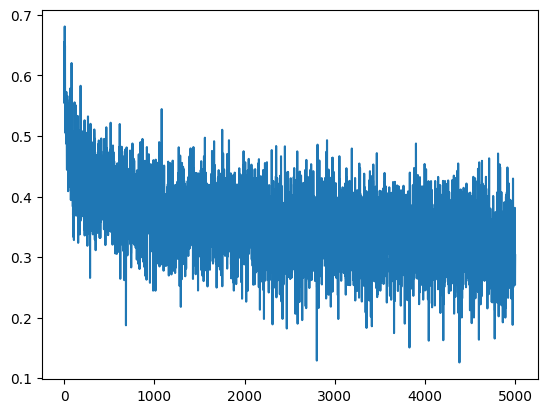

In [9]:
# training loop
import matplotlib.pyplot as plt
%matplotlib inline
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

steps, losses = [], []
Btr = 64
for step in range(5000):
    X_BT, Y_BT = gen_dataset(data[:n1])
    logits_BTV, loss = m(X_BT, Y_BT)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    steps.append(step)
    losses.append(loss.log10().item())

plt.plot(steps, losses)
print(loss.item())

In [10]:
X_BT = torch.zeros((1,1), dtype=torch.long) # B=1,T=1 for inference
Yh_BTplusN = m.generate(X_BT=X_BT, N=2000)
Yh_BTplusNdecoded = ''.join([decode[i] for i in Yh_BTplusN[0].tolist()]) # 0 since B = 1 for inference
print(Yh_BTplusNdecoded)


Awildrther nates,
Edwongutss and not hatce seep
And waitasested
no the jeet senge.

SEGLANEO:
Nosh heraht sar, dr, seneis liser shat gral fures ape ciet lore gristry sins it not Ed, put it andand ereerrs tiseg onges, your way?
Come insers oud mome, the wele bunle, my wild alls dus tou. the vornour hath werpout your cronser!

Weter
Ros erand be torne, !tere the seen untrent and he berold at it it no shose Tut
Onre ere tere sen suro
withe in enfuld torkins you hasater ds ga; us,
Buldy saten your chis mous:

Gthou bat nem don,
Nose nest of lady?
Whis ten gonings, on eldond disond, de with
Io hattel nay, on we in auk Edund yet, Is that yes sit is unjeli drast bria . untre heds the
Romet heardicher, and a we jeee imsed e taseour ears and him ap ins ifuick with:
Go you kinksprets
Whe on ge, and pperain eard chour shatiim, gond inds art yet.

NORD ARD:
Hatisere dow in my strust it shim day. Edwad and lors nay youu hating turs umpass, jod him benossey cartintiritt things?
And it he son buly f